In [102]:
import re
import os
import numpy as np
import scipy.interpolate as interp
from scipy.ndimage import map_coordinates

from camera_model import CameraModel
from transform import build_se3_transform
from image import load_image
from interpolate_poses import interpolate_vo_poses, interpolate_ins_poses

from PIL import Image

import matplotlib.pyplot as plt

import cv2

### Directories

In [19]:
image_dir = '/home/parallels/cse291/monodepth/data/robotcar/sample/stereo/left/'
extrinsics_dir = '/home/parallels/cse291/robotcar-dataset-sdk/extrinsics/'
models_dir = '/home/parallels/cse291/robotcar-dataset-sdk/models/'
lidar_dir = '/home/parallels/cse291/monodepth/data/robotcar/sample/ldmrs/'

vo_poses_file = ''
ins_poses_file = '/home/parallels/cse291/monodepth/data/robotcar/sample/gps/ins.csv'

#### Which image(s)

In [266]:
img_index = 260

### Camera Extrinsics

In [267]:
model = CameraModel(models_dir, image_dir)

extrinsics_path = os.path.join(extrinsics_dir, model.camera + '.txt')
with open(extrinsics_path) as extrinsics_file:
    extrinsics = [float(x) for x in next(extrinsics_file).split(' ')]

G_camera_vehicle = build_se3_transform(extrinsics)

### Build Pointclouds for VO and INS

In [268]:
# Timestamps for Pointcloud Generation
start_time = 1418381798113072
end_time = 1418381817070979

In [269]:
lidar = re.search('(lms_front|lms_rear|ldmrs)', lidar_dir).group(0)
timestamps_path = os.path.join(lidar_dir, os.pardir, lidar + '.timestamps')

timestamps = []
with open(timestamps_path) as timestamps_file:
    for line in timestamps_file:
        timestamp = int(line.split(' ')[0])
        if start_time <= timestamp <= end_time:
            timestamps.append(timestamp)

if len(timestamps) == 0:
    raise ValueError("No LIDAR data in the given time bracket.")


### Process Image(s)

In [270]:
timestamps_path = os.path.join(image_dir, os.pardir, model.camera + '.timestamps')
if not os.path.isfile(timestamps_path):
    timestamps_path = os.path.join(image_dir, os.pardir, os.pardir, model.camera + '.timestamps')

with open(timestamps_path) as timestamps_file:
    for i, line in enumerate(timestamps_file):
        if i == img_index:
            timestamp_img = int(line.split(' ')[0])
            
image_path = os.path.join(image_dir, str(timestamp_img) + '.png')
image = load_image(image_path, model)

#### VO Pointcloud

In [271]:
# sensor is VO, which is located at the main vehicle frame
with open(os.path.join(extrinsics_dir, lidar + '.txt')) as extrinsics_file:
    extrinsics = next(extrinsics_file)
G_posesource_laser = build_se3_transform([float(x) for x in extrinsics.split(' ')])

poses = interpolate_vo_poses(vo_poses_file, timestamps, timestamp_img)

pointcloud_vo = np.array([[0], [0], [0], [0]])

for i in range(0, len(poses)):
    scan_path = os.path.join(lidar_dir, str(timestamps[i]) + '.bin')
    if not os.path.isfile(scan_path):
        continue

    scan_file = open(scan_path)
    scan = np.fromfile(scan_file, np.double)
    scan_file.close()
    scan = scan.reshape((len(scan) // 3, 3)).transpose()
    scan = np.dot(np.dot(poses[i], G_posesource_laser), np.vstack([scan, np.ones((1, scan.shape[1]))]))
    pointcloud_vo = np.hstack([pointcloud_vo, scan])

pointcloud_vo = pointcloud_vo[:, 1:]
pointcloud_vo = np.dot(G_camera_vehicle, pointcloud_vo)

IOError: [Errno 2] No such file or directory: ''

#### GPS INS Pointcloud

In [272]:
with open(os.path.join(extrinsics_dir, 'ins.txt')) as extrinsics_file:
    extrinsics = next(extrinsics_file)
    G_posesource_laser = np.linalg.solve(build_se3_transform([float(x) for x in extrinsics.split(' ')]),
                                         G_posesource_laser)
    G_camera_posesource = G_camera_vehicle * build_se3_transform([float(x) for x in extrinsics.split(' ')])
    
poses = interpolate_ins_poses(ins_poses_file, timestamps, timestamp_img)

pointcloud_ins = np.array([[0], [0], [0], [0]])

for i in range(0, len(poses)):
    scan_path = os.path.join(lidar_dir, str(timestamps[i]) + '.bin')
    if not os.path.isfile(scan_path):
        continue

    scan_file = open(scan_path)
    scan = np.fromfile(scan_file, np.double)
    scan_file.close()
    scan = scan.reshape((len(scan) // 3, 3)).transpose()
    scan = np.dot(np.dot(poses[i], G_posesource_laser), np.vstack([scan, np.ones((1, scan.shape[1]))]))
    pointcloud_ins = np.hstack([pointcloud_ins, scan])

pointcloud_ins = pointcloud_ins[:, 1:]
pointcloud_ins = np.dot(G_camera_posesource, pointcloud_ins)

#### Sparse Local Pointcloud

In [273]:
lidar = re.search('(lms_front|lms_rear|ldmrs)', lidar_dir).group(0)
timestamps_path = os.path.join(lidar_dir, os.pardir, lidar + '.timestamps')

#timestamps = []
with open(timestamps_path) as timestamps_file:
    for line in timestamps_file:
        this_timestamp = int(line.split(' ')[0])
        if this_timestamp >= timestamp_img:
            timestamp_lidar = this_timestamp
            break

            
            
with open(os.path.join(extrinsics_dir, lidar + '.txt')) as extrinsics_file:
    extrinsics = next(extrinsics_file)
G_posesource_laser = build_se3_transform([float(x) for x in extrinsics.split(' ')])

local_pointcloud = np.array([[0], [0], [0], [0]])

scan_path = os.path.join(lidar_dir, str(timestamp_lidar) + '.bin')

scan_file = open(scan_path)
scan = np.fromfile(scan_file, np.double)
scan_file.close()

scan = scan.reshape((len(scan) // 3, 3)).transpose()

scan = np.dot(G_posesource_laser, np.vstack([scan, np.ones((1, scan.shape[1]))]))
local_pointcloud = np.hstack([local_pointcloud, scan])

local_pointcloud = local_pointcloud[:, 1:]
local_pointcloud = np.dot(G_camera_vehicle, local_pointcloud)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.


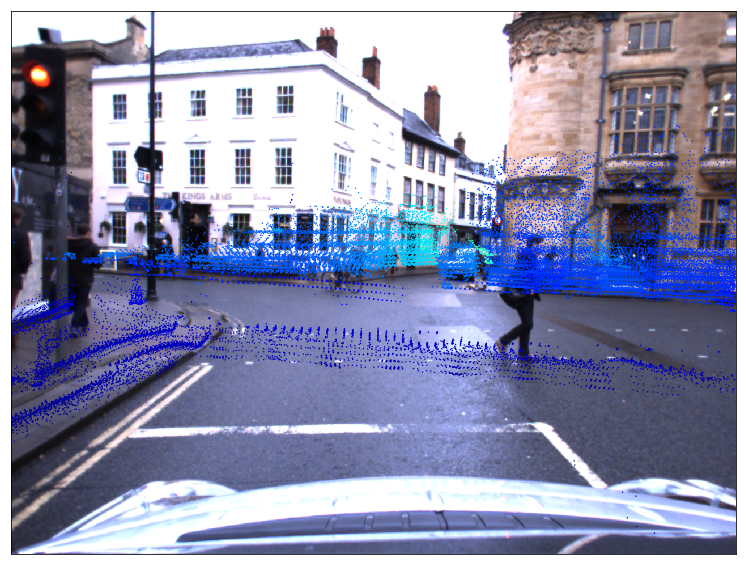

In [274]:
uv, depth = model.project(pointcloud_ins, image.shape)
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.hold(True)
plt.scatter(np.ravel(uv[0, :]), np.ravel(uv[1, :]), s=2, c=depth, edgecolors='none', cmap='jet')
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.xticks([])
plt.yticks([])
plt.savefig('projected.png')
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.


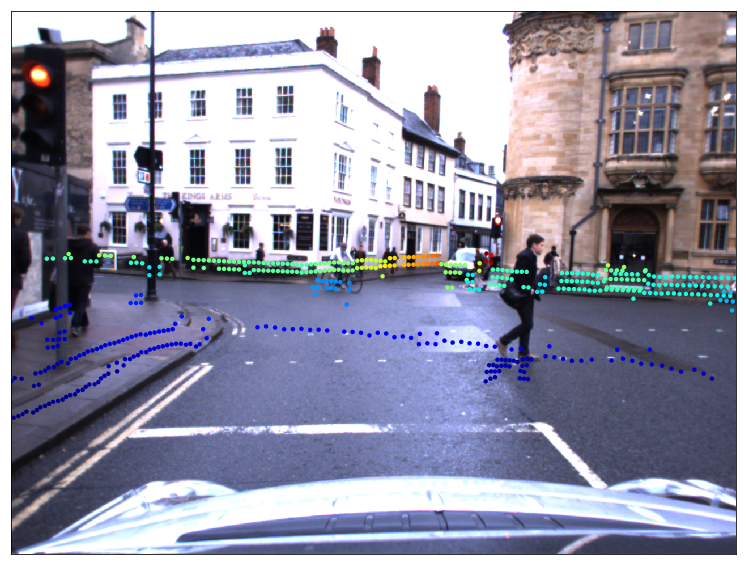

In [275]:
uv, depth = model.project(local_pointcloud, image.shape)
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.hold(True)
plt.scatter(np.ravel(uv[0, :]), np.ravel(uv[1, :]), s=20, c=depth, edgecolors='none', cmap='jet')
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.xticks([])
plt.yticks([])
plt.savefig('projected.png')
plt.show()



In [288]:
min(depth)

4.973639159256104

In [276]:
len(depth)

496

In [277]:
uv

matrix([[5.20935743e+00, 1.34997657e+01, 2.09691350e+01, 2.76992355e+01,
         3.96918555e+01, 1.21910975e+00, 4.63563512e+01, 7.27801544e+00,
         5.23976076e+01, 1.93518366e+01, 6.05664444e+01, 4.10561072e+01,
         6.77275177e+01, 4.97546243e+01, 7.49216933e+01, 4.37059523e+01,
         8.36586864e+01, 5.27295879e+01, 9.17381264e+01, 6.08268074e+01,
         9.77947634e+01, 6.68682904e+01, 1.05052105e+02, 7.62264104e+01,
         6.53482957e+01, 6.45875274e+01, 3.67093198e+01, 1.13646247e+02,
         8.26515467e+01, 7.49654560e+01, 7.50186745e+01, 1.18628464e+02,
         8.95865832e+01, 8.34275472e+01, 5.46393444e+01, 8.45567811e+01,
         1.26944910e+02, 1.01482008e+02, 8.51936604e+01, 8.62769318e+01,
         1.32429067e+02, 1.06023670e+02, 9.53000740e+01, 9.50543966e+01,
         1.38966322e+02, 1.14860553e+02, 7.98074533e+01, 7.92036831e+01,
         1.48115517e+02, 1.21504978e+02, 8.79490292e+01, 8.76804546e+01,
         1.54693214e+02, 1.29424478e+02, 9.57572935

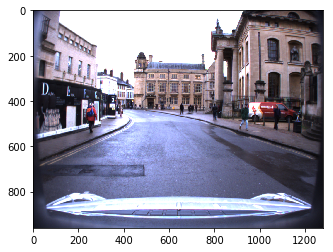

In [278]:
os.chdir('/home/parallels/cse291/robotcar-dataset-sdk/python/')
from image import load_image
os.chdir('../../..')

image_path = '/home/parallels/cse291/monodepth/data/robotcar/sample/stereo/centre/1418381804950808.png'
img = load_image(image_path)
plt.imshow(img)
img = Image.fromarray(img)
img.save("/home/parallels/cse291/robotcar-dataset-sdk/test_images/test.png")

In [79]:
gt_depth = {str(timestamp_img) + '.png':np.vstack((uv, depth)).transpose()}
np.save('gt.npy', gt_depth)

In [87]:
print(image_path)

/home/parallels/cse291/monodepth/data/robotcar/sample/stereo/left/1418381804950808.png


In [92]:
!python /home/parallels/cse291/monodepth/monodepth_simple.py --image_path /home/parallels/cse291/robotcar-dataset-sdk/test_images/test.png --checkpoint_path /home/parallels/cse291/monodepth/model_kitti/model_kitti.ckpt

2018-02-09 14:49:10.525703: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
done!


In [279]:
def compute_errors(gt_depths, pred_depths):
    gt = []
    pred = []
    for t in gt_depths:
        gt.append(t[2])
        pred.append(pred_depths[int(t[1])-1][int(t[0])-1])
    gt = np.array(gt)
    pred = np.array(pred)
    #thresh = np.maximum((gt / pred), (pred / gt))
    #a1 = (thresh < 1.25   ).mean()
    #a2 = (thresh < 1.25 ** 2).mean()
    #a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred)**2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log

In [280]:
pred_disparities = np.load('/home/parallels/cse291/robotcar-dataset-sdk/test_images/test_disp.npy')

In [281]:
def convert_disps_to_depths(pred_disp, height, width):

    pred_disp = width * cv2.resize(pred_disp, (width, height), interpolation=cv2.INTER_LINEAR)

    pred_depths = 983.044006 * 0.24 / pred_disp
    
    return pred_depths

In [282]:
pred_depth = convert_disps_to_depths(pred_disparities, 960, 1280)

In [283]:
gt_depth = np.asarray(np.vstack((uv, depth)).transpose())

In [284]:
print(gt_depth)

[[   5.20935743  718.9013086     4.97363916]
 [  13.49976567  716.07360048    5.02372127]
 [  20.96913496  712.46500662    5.08866956]
 ...
 [1207.36376581  633.99388125    8.06511091]
 [1223.62180788  640.87400932    7.79043315]
 [1238.46924485  649.73374624    7.45512657]]


In [286]:
compute_errors(gt_depth, pred_depth)

(0.26879462695717915, 2.38094764432446, 8.0611513547521, 0.39368205421645963)

In [216]:
max(gt_depth[0])

605.2633479999291

In [172]:
max(gt_depth[:,0])

1278.6590179813975